In [64]:
# モジュール
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pylab as plt

# 読み込み & 日付でソート
twtr_stock = pd.read_csv('HistoricalQuotes.csv').sort_values('Date').reset_index(drop=True)

In [65]:
# 末尾30件を検証データとして分割
train_df = twtr_stock[0:-30].reset_index(drop=True)
test_df = twtr_stock[-30:].reset_index(drop=True)

In [66]:
twtr_stock.head()

,Date,Close,Volume,Open,High,Low
0,01/02/2020,32.30,10694420,32.31,32.500,31.96
1,01/03/2020,31.52,14440380,31.71,32.100,31.26
2,01/06/2020,31.64,12585830,31.23,31.710,31.16
3,01/07/2020,32.54,13998270,31.80,32.695,31.72
4,01/08/2020,33.05,14637340,32.35,33.400,32.35


In [67]:
twtr_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    200 non-null    object 
 1   Close   200 non-null    float64
 2   Volume  200 non-null    int64  
 3   Open    200 non-null    float64
 4   High    200 non-null    float64
 5   Low     200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.5+ KB


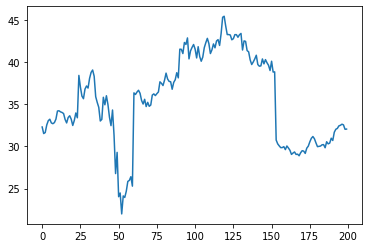

In [68]:
plt.plot(twtr_stock['Close'])

In [69]:
TRAIN_SIZE = 20
TARGET_FUTURE = 5
WINDOW_SIZE =  TRAIN_SIZE + TARGET_FUTURE

def split_window_data(array, window_size):
    length = array.shape[0]
    roop_num = length - window_size + 1
    window_data = np.stack([
        np.hstack(
            np.array(array[i: i+window_size].astype('float64')).reshape(window_size, 1)
        )
        for i in range(roop_num)
    ])
    return window_data

train_close = np.array(train_df['Close'])
window_data = split_window_data(train_close, WINDOW_SIZE)

In [70]:
# 標準化
sc = StandardScaler()
window_sc = np.stack([
    np.hstack(sc.fit_transform(vec.reshape(WINDOW_SIZE, 1)))
    for vec in window_data
])

In [71]:
def curve_clustering(array, curve_len):
    train = np.stack([vec[0:curve_len] for vec in array])
    test = np.stack([vec[curve_len:] for vec in array])
    test_len = test.shape[1]
    
    # PCA
    pca = PCA(n_components=curve_len)
    pca.fit(train)
    
    # 共分散行列から写像
    cov_mtrx = pca.get_covariance()
    train_pca = np.dot(train, cov_mtrx)
    
    # あとで元に戻すため、共分散行列の逆行列を求めておく
    cov_mtrx_inverse = np.linalg.inv(cov_mtrx)

    # k-meansクラスタリング
    curve_clst_size = int(np.sqrt(train_pca.shape[0]/2))
    cls = KMeans(n_clusters=curve_clst_size, random_state=123)
    curve_clst = cls.fit_predict(train_pca)
    
    # クラスタ毎に、カーブのリスト、平均、分散、代表ベクトルを求めておく
    curve_df = pd.DataFrame({
        'curve_clst': curve_clst
        , 'train': [vec for vec in train]
        , 'train_pca': [vec for vec in train_pca]
    })
    for i in range(test_len):
        curve_df['test{}'.format(i)] = [vec[i] for vec in test]
    print([col for col in curve_df.columns if 'test' in col])
    curve_clst_dict = {
        cluster : {
            'test_means': [df[col].mean() for col in df.columns if 'test' in col]
            , 'test_medians': [df[col].median() for col in df.columns if 'test' in col]
            , 'test_stds': [df[col].std() for col in df.columns if 'test' in col]
            , 'train_cluster_center': np.dot(cls.cluster_centers_[cluster].flatten(), cov_mtrx_inverse)
            , 'train_pca_cluster_center': cls.cluster_centers_[cluster].flatten()
            , 'train_vectors': [vec for vec in df['train']]
            , 'train_pca_vectors': [vec for vec in df['train_pca']]
        }
        for cluster, df in curve_df.groupby('curve_clst')
    }
    return (curve_clst_dict, cls, pca)

curve_clst_dict, cls, pca = curve_clustering(window_sc, TRAIN_SIZE)

['test0', 'test1', 'test2', 'test3', 'test4']


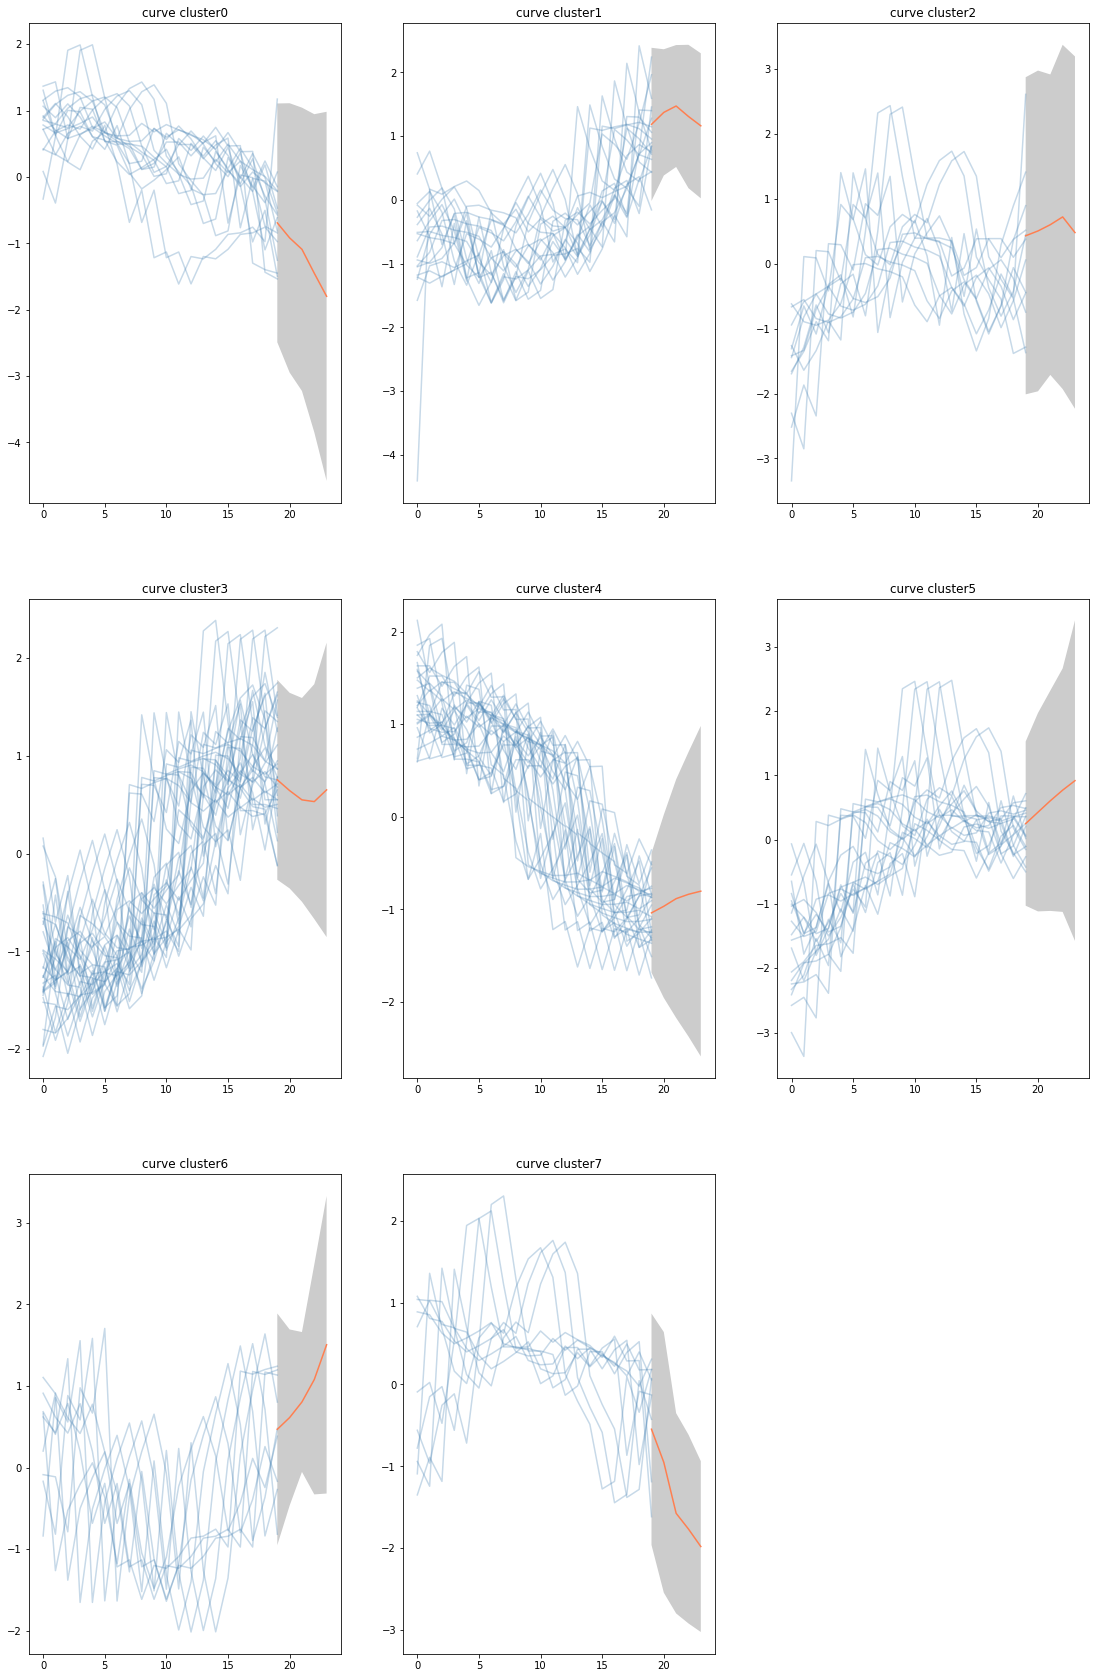

In [72]:
# グラフを行列形式で表示する
clst_size = len(curve_clst_dict)
row_size = int(clst_size/3) if clst_size%3 == 0 else int(clst_size/3) + 1
x_axis = [x for x in range(WINDOW_SIZE - 1)]

fig = plt.figure(figsize=(19,30))
for key in curve_clst_dict:
    # カーブのリストを取り出す
    clst_info = curve_clst_dict[key]
    raw_curves = clst_info['train_vectors']
    
    # subplotと行列番号の設定
    row_n = int(key/3)
    col_n = key%3
    ax = plt.subplot2grid((row_size,3), (row_n, col_n))
    
    # カーブのプロット
    for raw_curve in raw_curves:
        ax.plot(raw_curve, color='steelblue', alpha=0.3)
        
    # 区間のプロット
    upper_95 = np.hstack([np.repeat(np.nan, TRAIN_SIZE-1), np.array(clst_info['test_means']) + 2*np.array(clst_info['test_stds'])])
    lower_95 = np.hstack([np.repeat(np.nan, TRAIN_SIZE-1), np.array(clst_info['test_means']) - 2*np.array(clst_info['test_stds'])])
    ax.fill_between(x_axis, upper_95, lower_95, facecolor='gray', alpha=0.4)
    
    # 平均値のプロット
    ax.plot(list(np.repeat(np.nan, TRAIN_SIZE-1)) + list(clst_info['test_means']), color='coral')
    ax.set_title('curve cluster{}'.format(key))
plt.show()

In [73]:
# TRAIN_SIZEで分割
window_data_train = split_window_data(train_close, TRAIN_SIZE)

# 標準化
sc = StandardScaler()
window_sc_train = sc.fit_transform(window_data_train.T).T

In [74]:
# cos類似度を計算する関数
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# もっとも類似度の高いクラスタの番号を返す関数
def calculate_neighbor_clst(window_vec, curve_dict):
    cos_sim_vec = np.array([
       cos_sim(window_vec, curve_clst_dict[clst]['train_cluster_center'])
       for clst in curve_clst_dict])
    return cos_sim_vec.argmax()

In [75]:
# もっとも近いクラスタの平均値を取り出す
scaled_means = []
for vec in window_sc_train:
    neighbor_clst = calculate_neighbor_clst(vec, curve_clst_dict)
    scaled_mean = np.array(curve_clst_dict[neighbor_clst]['test_means'][TARGET_FUTURE - 1])
    scaled_means.append(scaled_mean)
    
# 取り出した平均値を元のスケールに戻す
scaled_means = np.array(scaled_means)
pred_means = sc.inverse_transform(scaled_means)

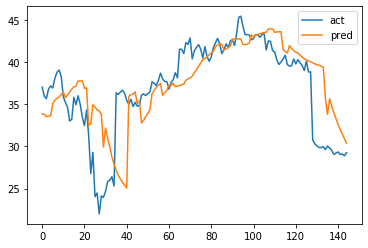

In [76]:
act = train_close[WINDOW_SIZE:]
pred = pred_means[0:-TARGET_FUTURE-1].flatten().tolist()
plt.plot(act, label='act')
plt.plot(pred, label='pred')
plt.legend()

In [77]:
# 20日目の株価と５日後の実際の株価を比べ、上がってるor下がってるか
act_updown = [
    train_close[i + WINDOW_SIZE] > train_close[i + TRAIN_SIZE] 
    for i in range(len(train_close) - WINDOW_SIZE)
]
# 20日目の株価と５日後の予測株価を比べ、上がってるor下がってるか
pred_updown = [
    pred[i] > train_close[i + TARGET_FUTURE]
    for i in range(len(train_close) - WINDOW_SIZE)
]

In [78]:
TF = (np.array(act_updown) == np.array(pred_updown))
sum(TF)/len(TF)

0.5793103448275863

In [79]:
# スライド窓から予測値を算出する関数
def predict_(window_vec, target_future):
    test_sc = StandardScaler()
    vec_sc = test_sc.fit_transform(window_vec.reshape(TRAIN_SIZE, 1)).T
    neighbor_clst = calculate_neighbor_clst(vec_sc, curve_clst_dict)
    scaled_mean = np.array(curve_clst_dict[neighbor_clst]['test_means'][target_future]).reshape(-1, 1)
    return test_sc.inverse_transform(scaled_mean.reshape(-1,1))

# 予測値を追加しながら、次点の値を予測
def predict_forward(window_vec, n_forward, target_future):
    predictions = []
    vec_len = window_vec.shape[0]
    train_vec = window_vec.copy()
    for _ in range(n_forward):
        pred = predict_(train_vec, target_future).flatten()
        predictions.append(pred[0])
        train_vec = np.append(train_vec[-vec_len + 1:], pred)
    return predictions 

# テストデータの長さ分の予測値を算出
test_len = len(test_df)
last_window = window_data_train[-1]
predictions = predict_forward(last_window, test_len, TARGET_FUTURE-1)

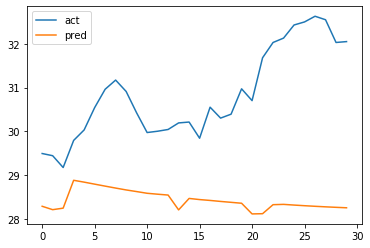

In [80]:
plt.plot(test_df['Close'], label='act')
plt.plot(predictions, label='pred')
plt.legend()